<a href="https://colab.research.google.com/github/sehan25/ESAA-2022-1/blob/main/Assignment/0627_Python_Machine_Learning_p452_p465.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **06. 군집화 실습 - 고객 세그먼테이션**
---

> ### 고객 세그먼테이션의 정의와 기법
> ---

고객 세그먼테이션(Customer Segmentation): 다양한 기준으로 고객을 분류하는 기법
- 고객 세그먼테이션은 CRM이나 마케팅의 중요 기반 요소이다.
- 고객 세그먼테이션의 주요 목표는 타깃 마케팅이다.
    - 타깃 마케팅: 고객을 여러 특성에 맞게 세분화해서 그 유형에 따라 맞춤형 마케팅이나 서비스를 제공하는 것
- 고객 세그먼테이션은 고객의 어떤 요소를 기반으로 군집화할 것인가를 결정하는 것이 중요한데, 여기서는 기본적인 고객 분석 요소인 RFM 기법을 이용할 것이다.
    - RECENCY (R): 가장 최근 상품 구입 일에서 오늘까지의 기간
    - FREQUENCY (F): 상품 구매 횟수
    - MONETARY VALUE (M): 총 구매 금액

> ### 데이터 세트 로딩과 데이터 클렌징
> ---

In [1]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')
retail_df = pd.read_excel(io='/content/drive/MyDrive/ESAA/data/Online Retail.xlsx')
retail_df.head(3)

Mounted at /content/drive


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


- 데이터 세트의 각 칼럼
    - InvoiceNo: 주문번호. 'C'로 시작하는 것은 취소 주문
    - StockCode: 제품 코드(Item Code)
    - Description: 제품 설명
    - Quantity: 주문 제품 건수
    - InvoiceDate: 주문 일자
    - UnitPrice: 제품 단가
    - CustomerID: 고객 번호
    - Country: 국가명(주문 고객의 국적)

In [2]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


- 사전 정제 작업
    - Null 데이터 제거 : 특히 CustomerID가 Nul인 데이터가 많음. 고객 식별 번호가 없는 데이터는 필요가 없기에 삭제
    - 오류 데이터 삭제: 대표적인 오류 데이터는 Quantity 또는 UnitPrice가 0보다 작은 경우

In [3]:
## 사전 정제

retail_df = retail_df[retail_df['Quantity'] > 0]
retail_df = retail_df[retail_df['UnitPrice'] > 0]
retail_df = retail_df[retail_df['CustomerID'].notnull()]
print(retail_df.shape)
retail_df.isnull().sum()

(397884, 8)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

- - 주요 주문 고객은 영국인데, 이 외에도 EU의 여러 나라와 영연방 국가들이 포함돼 있ㅇ므로 다른 국가 데이터 모두 제외

In [4]:
retail_df['Country'].value_counts()[:5]

United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Name: Country, dtype: int64

In [5]:
## 추가 작업

retail_df = retail_df[retail_df['Country']=='United Kingdom']
print(retail_df.shape)

(354321, 8)


> ### RFM 기반 데이터 가공
> ---

*사전 정제된 데이터 기반으로 고객 세그먼테이션 군집화를 RFM 기반으로 수행*
- 필요한 데이터 가공
    - 'UnitPrice'와 'Quantity'를 곱해서 주문 금액 데이터 만듦
    - CustomerNo도 더 편리한 식별성 위해 float형을 int형으로 변경

In [6]:
## 데이터 가공

retail_df['sale_amount'] = retail_df['Quantity'] * retail_df['UnitPrice']
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)

- 해당 온라인 판매 데이터 세트는 주문 횟수와 주문 금액이 압도적으로 특정 고객에게 많은 특성을 가지고 있다.
- 개인 고객의 주문과 소매점의 주문이 함께 포함돼 있기 때문이다.

In [7]:
## Top-5 주문 건수와 주문 금액을 가진 고객 데이터 추출

print(retail_df['CustomerID'].value_counts().head(5))
print(retail_df.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending=False)[:5])

17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: CustomerID, dtype: int64
CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64


- 주어진 온라인 판매 데이터 세트는 전형적인 판매 데이터 세트와 같이 주문번호(InvoiceNo) + 상품코드(StockCode) 레벨의 식별자로 되어 있다.
- InvoiceNo + StockCode로 groupby 수행하면 거의 1에 가깝게 유일한 식별자 레벨이 됨을 알 수 있다.

In [8]:
retail_df.groupby(['InvoiceNo','StockCode'])['InvoiceNo'].count().mean()

1.028702077315023

- 수행하려는 RFM 기반의 고객 세그멘테이션은 고객 레별로 주문 기간, 주문 횟수, 주문 금액 데이터를 기반으로 해 세그먼테이션을 수행하는 것이다.
- 주문번호+상품코드 기준의 데이터를 고객 기준의 Recencey, Frequency, Monetary value 데이터로 변경

In [9]:
## 주문번호+상품코드 기준의 데이터를 고객 기준의 Recencey, Frequency, Monetary value 데이터로 변경

# DataFrame의 groupby() 의 multiple 연산을 위해 agg() 이용
# Recency는 InvoiceDate 칼럼의 max()에서 데이터 가공
# Frequency는 InvoiceNo 칼럼의 count(), Monetary value는 sale_amount 칼럼의 sum()
aggregations = {
    'InvoiceDate': 'max',
    'InvoiceNo': 'count',
    'sale_amount':'sum'
}
cust_df = retail_df.groupby('CustomerID').agg(aggregations)
# groupby된 결과 컬럼값을 Recency, Frequency, Monetary로 변경
cust_df = cust_df.rename(columns = {'InvoiceDate':'Recency',
                                    'InvoiceNo':'Frequency',
                                    'sale_amount':'Monetary'
                                   }
                        )
cust_df = cust_df.reset_index()
cust_df.head(3)

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73


- Recency 칼럼은 개별 고객당 가장 최근의 주문인데, 데이터 값의 특성으로 인해 아직 데이터 가공 추가 필요
    - Recency는 고객이 가장 최근에 주문한 날짜를 기반으로 하는데, 오늘 날짜를 기준으로 가장 최근 주문 일자를 뺀 날짜임.
    - 온라인 판매 데이터가 2010년 12월 1일에서 2011년 12월 9일까지의 데이터이므로 오늘 날짜는 2011년 12월 9일에서 하루 더한 2011년 12월 10일로 간주하여, 가장 최근의 주문 일자를 뺀 데이터에서 일자 데이터(days)만 추출해 생성

In [10]:
## Recency 칼럼 추가 가공

import datetime as dt

cust_df['Recency'] = dt.datetime(2011,12,10) - cust_df['Recency']
cust_df['Recency'] = cust_df['Recency'].apply(lambda x: x.days+1)
print('cust_df 로우와 컬럼 건수는 ', cust_df.shape)
cust_df.head(3)

cust_df 로우와 컬럼 건수는  (3920, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73


> RFM 기반 고객 세그먼테이션
> ---

- 온라인 판매 데이터 세트는 주문 횟수와 주문 금액에서 개인 고객 주문과 소매업체 주문이 매우 큰 차이를 나타내고 있으며 이로 인해 매우 왜곡된 데이터 분포도를 가지게 되어 군집화가 한쪽 군집에만 집중되는 현상이 발생하게 된다.

(array([3.887e+03, 1.900e+01, 9.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([3.75000000e+00, 2.59691050e+04, 5.19344600e+04, 7.78998150e+04,
        1.03865170e+05, 1.29830525e+05, 1.55795880e+05, 1.81761235e+05,
        2.07726590e+05, 2.33691945e+05, 2.59657300e+05]),
 <a list of 10 Patch objects>)

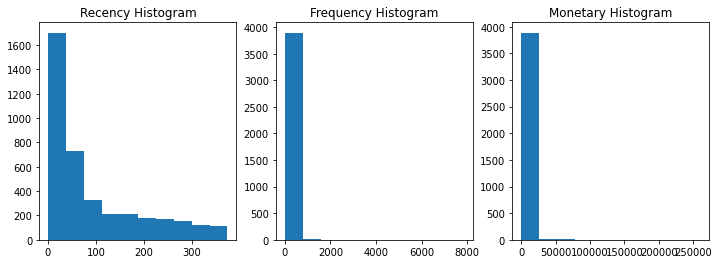

In [11]:
## 칼럼 값 분포 히스토그램

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12,4), nrows=1, ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary'])

In [12]:
## 각 칼럼의 데이터 값 백분위로 대략적으로 어떻게 값이 분포돼 있는지 확인

cust_df[['Recency', 'Frequency', 'Monetary']].describe()

,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,92.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,300.280000
50%,51.000000,41.000000,652.280000
75%,143.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


- 왜곡 정도가 매우 높은 데이터 세트에 K-평균 군집을 적용하면 중심의 개수를 증가시키더라도 변별력이 떨어지는 군집화가 수행된다.
- 데이터 세트를 StandardScaler로 평균과 표준편차를 재조정한 뒤에 K-평균을 수행

In [13]:
## 데이터 세트를 StandardScaler로 평균과 표준편차를 재조정한 뒤에 K-평균을 수행

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features = cust_df[['Recency','Frequency','Monetary']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는: {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))

실루엣 스코어는: 0.592


- 2절 군집평가 예제에서 사용한 `visualized_silhouette()` 함수와 군집 개수별로 군집화 구성을 시각화하는 `visualize_kmeans_plot_multi()` 함수를 새롭게 생성하여 군집 개수 변화시키면서 개별 군집의 실루엣 계수 값과 데이터 구성 알아보기

In [14]:
## 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성  

def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster: '+ str(n_cluster)+'\n' \
                          'Silhouette Score:' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [15]:
## 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 클러스터링 결과를 시각화 

def visualize_kmeans_plot_multi(cluster_lists, X_features):
    
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']
       
        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)           
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster: '+ str(n_cluster))    
        axs[ind].legend(loc='upper right')
    
    plt.show()

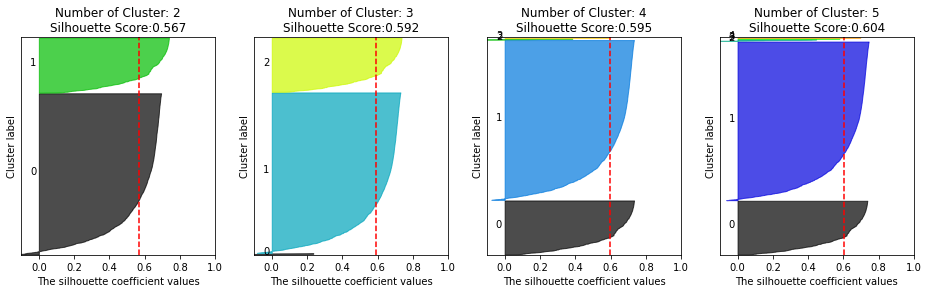

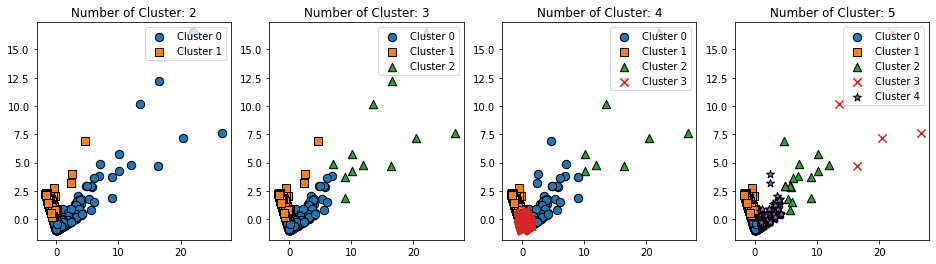

In [16]:
visualize_silhouette([2,3,4,5], X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5], X_features_scaled)

    군집이 2개일 경우 0번 군집과 1번 군집이 너무 개괄적으로 군집화됨.
    군집이 3개 이상일 때부터는 데이터 세트의 개수가 너무 작은 군집이 만들어짐
    이 군집에 속한 데이터는 개수가 작을 뿐더러 실루엣 계수 역시 상대적으로 매우 작음
    또한 군집 내부에서도 데이터가 광범위하게 퍼져 있음.
    군집이 3개일 때는 0번 군집의 데이터 건수가 매우 작고,
    4개일 때는 2번,3번 군집이,
    5개일 때는 2,3,4번 군집에 속한 데이터 세트의 개수가 너무 적고 광범위하게 퍼져 있음.
    이 소수의 데이터 세트는 바로 앞에서 왜곡된 데이터 값인 특정 소매점의 대량 주문 구매 데이터임.

- 이 정도로 크게 왜곡된 데이터 세트의 도출은 굳이 군집화를 이용하지 않고도 간단한 데이터 분석만으로도 충분히 가능하다.
- 지나치게 왜곡된 데이터 세트는 K-평균과 같은 거리 기반 군집화 알고리즘에서 지나치게 일반적인 군집화 결과를 도출하게 된다.
- 데이터 세트의 왜곡 정도를 낮추기 위해 가장 자주 사용되는 방법은 데이터 값에 로그(Log)를 적용하는 로그 변환이다.
- 전체 데이터를 로그 변환한 뒤에 K-평균 알고리즘을 적용하고 결과 비교

In [17]:
## 전체 데이터를 로그 변환한 뒤에 K-평균 알고리즘을 적용하고 결과 비교

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Recency, Frequecny, Monetary 컬럼에 np.log1p()로 Log Transformation
cust_df['Recency_log'] = np.log1p(cust_df['Recency'])
cust_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_df['Monetary_log'] = np.log1p(cust_df['Monetary'])

# Log Transformation 데이터에 StandardScaler 적용
X_features = cust_df[['Recency_log', 'Frequency_log', 'Monetary_log']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는: {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))

실루엣 스코어는: 0.303


    실루엣 스코어는 로그 변환하기 전보다 떨어짐.
    하지만 실루엣 스코어의 절대치가 중요한 것이 아니고, 어떻게 개별 군집이 더 균일하게 나뉠 수 있는지가 더 중요함.

- 로그 변환한 데이터 세트를 기반으로 실루엣 계수와 군집화 구성 시각화

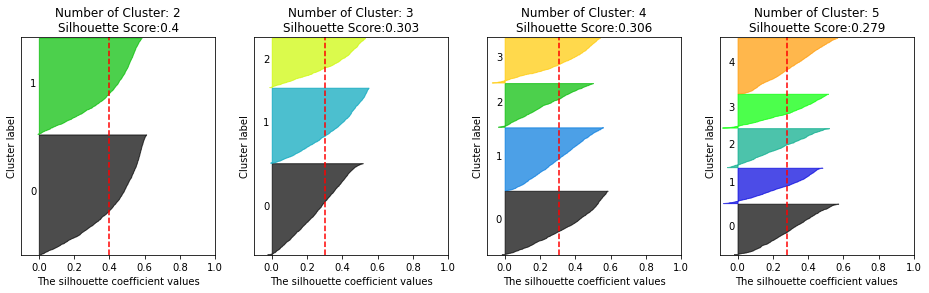

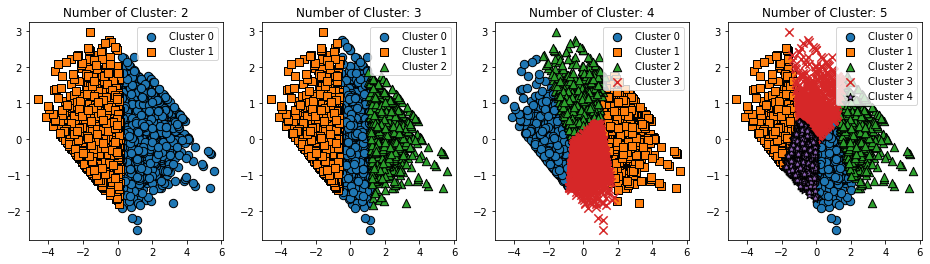

In [18]:
## 로그 변환한 데이터 세트를 기반으로 실루엣 계수와 군집화 구성 시각화

visualize_silhouette([2,3,4,5],X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5],X_features_scaled)

    실루엣 스코어는 로그 변환하기 전보다 떨어지지만 앞의 경우보다 더 균일하게 군집화가 구성됐음